### Import library

In [1]:
from argparse import ArgumentParser

from responsive_voice.voices import UKEnglishMale

from inference import FaceDetection, MaskDetection
from pyvino_utils import InputFeeder
from IPython import display

import cv2
import time
import numpy as np

from flask import Flask, render_template, Response

### Set the arguments

In [2]:
class setargs():
    face_model = "models/face-detection-adas-0001"
    mask_model = "models/face_mask"
    input = "cam"
    device = "GPU"
    face_prob_threshold = 0.8
    mask_prob_threshold = 0.3
    enable_speech = False
    tts = "Please wear your MASK!!"; # Text-to-Speech, used for notification.
    ffmpeg = False; # Flush video to FFMPEG
    show_bbox = True; # Show bounding box and stats on screen [debugging].
    debug = True; # Show output on screen [debugging].
    width = 640
    height = 480
    
args = setargs()

### Run the inferencing

#### Start the Web service

In [3]:
app = Flask("openvino")

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/video_feed')
def video_feed():
    return Response(gen_frames(), mimetype='multipart/x-mixed-replace; boundary=frame')

#### Initialize the video stream

In [4]:
input_feed = InputFeeder(input_feed=args.input)
input_feed.resize_cam_input(args.height, args.width)

2022-07-30 20:45:26.549 | INFO     | pyvino_utils.input_handler.input_feeder:load_feed:64 - Loaded input source type: cam
2022-07-30 20:45:26.599 | DEBUG    | pyvino_utils.input_handler.input_feeder:resize_cam_input:119 - Resized the webcam input to (480, 640)


#### Display the stream

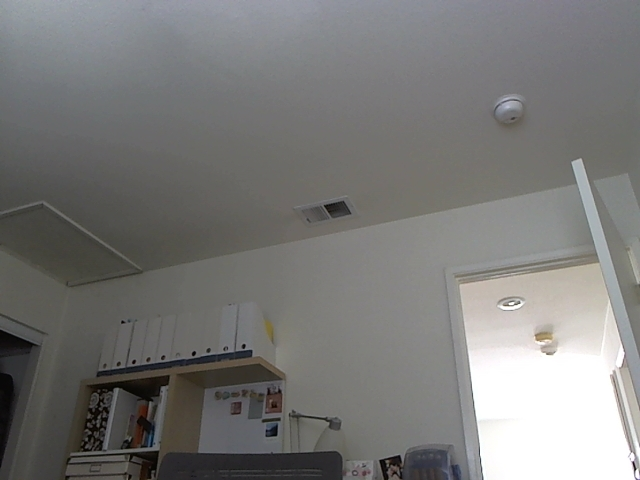

1it [00:00, 28.13it/s]


In [ ]:
for frame in input_feed.next_frame():
    # encode numpy array to jpg
    _, encoded_img = cv2.imencode(
        ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
    )
    # Below section is for sending the frame to the Jupyter notebook itself
    i = display.Image(data=encoded_img)
    # Display the image in this notebook
    display.clear_output(wait=True)
    display.display(i)

#### Enable speech output

In [ ]:
if args.enable_speech:
    # TODO: Add args for selecting language, accent and male/female voice
    engine = UKEnglishMale()
    speak = engine.get_mp3(args.tts)

#### Load the face detection model

In [ ]:
face_detection = FaceDetection(
    model_name=args.face_model,
    device=args.device,
    threshold=args.face_prob_threshold,
    input_feed=input_feed,
)

#### Load the mask detection model

In [ ]:
mask_detection = MaskDetection(
    model_name=args.mask_model,
    device=args.device,
    threshold=args.mask_prob_threshold,
)

#### Now, the inferencing loop

In [ ]:
count = 0
face_detect_infer_time = 0
mask_detect_infer_time = 0
mask_detected_prob = -1
try:
    # TODO: Convert to contextmanager
    face_detect_infer_time_samples = []
    mask_detect_infer_time_samples = []
    for frame in input_feed.next_frame():
        count += 1

        start_time = time.time()
        fd_results = face_detection.predict(
            frame, show_bbox=args.show_bbox, mask_detected=mask_detected_prob
        )
        face_detect_infer_time_samples.append(time.time() - start_time)
        face_bboxes = fd_results["process_output"]["bbox_coord"]
        if face_bboxes:
            for face_bbox in face_bboxes:
                # Useful resource:
                # https://www.pyimagesearch.com/2018/09/24/opencv-face-recognition/

                # Face bounding box coordinates cropped from the face detection
                # inference are face_bboxes i.e `xmin, ymin, xmax, ymax`
                # Therefore the face can be cropped by:
                # frame[face_bbox[1]:face_bbox[3], face_bbox[0]:face_bbox[2]]

                # extract the face ROI
                (x, y, w, h) = face_bbox
                face = frame[y:h, x:w]
                (face_height, face_width) = face.shape[:2]
                # Crop and show face
                # input_feed.show(frame[y:h, x:w], "face")

                # ensure the face width and height are sufficiently large
                if face_height < 20 or face_width < 20:
                    continue

                start_time = time.time()
                md_results = mask_detection.predict(
                    face, show_bbox=args.show_bbox, frame=frame
                )
                mask_detect_infer_time_samples.append(time.time() - start_time)
                mask_detected_prob = md_results["process_output"][
                    "flattened_predictions"
                ]
                if (
                    int(count) % 200 == 1
                    and args.enable_speech
                    and float(mask_detected_prob) < args.mask_prob_threshold
                ):
                    engine.play_mp3(speak)
                    
        # Calculate the avg inferecing time every 200 samples
        if int(count) % 5 == 1:
            if len(face_detect_infer_time_samples):
                face_detect_infer_time = np.mean(face_detect_infer_time_samples) * 1000
                face_detect_infer_time_samples = []
            else:
                face_detect_infer_time = 0
            if len(mask_detect_infer_time_samples):                        
                mask_detect_infer_time = np.mean(mask_detect_infer_time_samples) * 1000
                mask_detect_infer_time_samples = []
            else:
                mask_detect_infer_time = 0
                    
        if args.debug:
            text = f"Face Detection Inference time: {face_detect_infer_time:.3f} ms"
            input_feed.add_text(text, frame, (15, input_feed.source_height - 80))
            text = (
                f"Face Mask Detection Inference time: {mask_detect_infer_time:.3f} ms"
            )
            input_feed.add_text(text, frame, (15, input_feed.source_height - 60))
            
        # input_feed.show(input_feed.resize(frame))
        frame = input_feed.resize(frame)
        _, encoded_img = cv2.imencode(
            ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
        )
        i = display.Image(data=encoded_img)
        # Display the image in this notebook
        display.clear_output(wait=True)
        display.display(i)

finally:
    input_feed.close()